# Final project for "How to win a data science competition" Coursera course

## Importing Libraries

In [96]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

import random
random.seed(0)

STEPS = 26

## Loading Data

### File descriptions
* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
* sample_submission.csv - a sample submission file in the correct format.
* items.csv - supplemental information about the items/products.
* item_categories.csv  - supplemental information about the items categories.
* shops.csv- supplemental information about the shops.

In [2]:
trainData = pd.read_csv('./sales_train.csv', parse_dates=['date'])

### Data fields
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

In [3]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [4]:
trainData.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


array([[<AxesSubplot:title={'center':'date'}>,
        <AxesSubplot:title={'center':'date_block_num'}>],
       [<AxesSubplot:title={'center':'shop_id'}>,
        <AxesSubplot:title={'center':'item_id'}>],
       [<AxesSubplot:title={'center':'item_price'}>,
        <AxesSubplot:title={'center':'item_cnt_day'}>]], dtype=object)

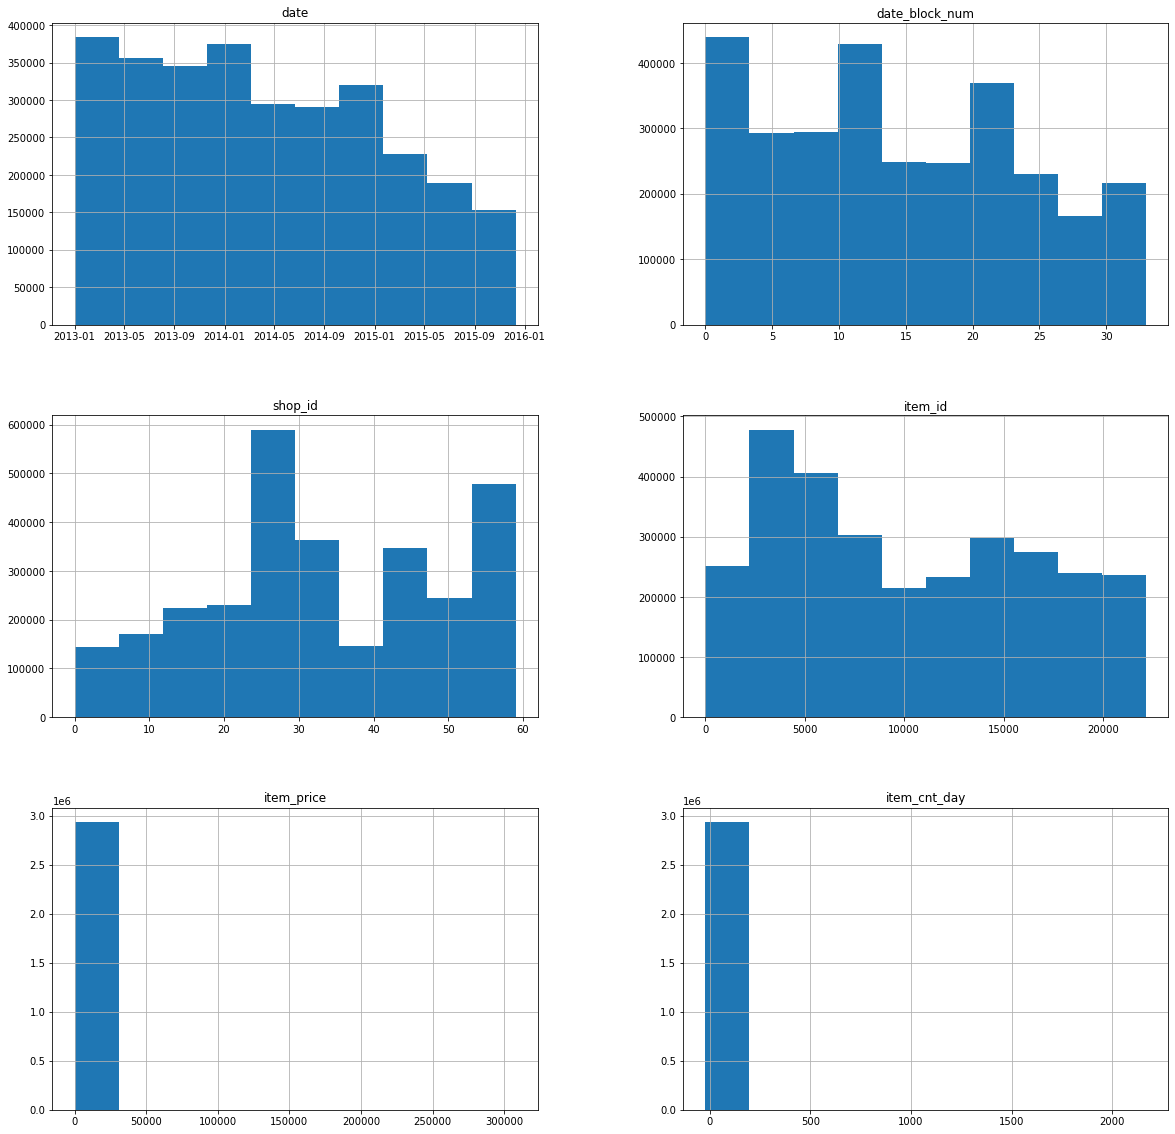

In [5]:
trainData.hist(figsize=(20, 20))

## Data Preprocessing

In [113]:
trainData = trainData[(trainData['item_price'] > 0) & (trainData['item_price'] < 10000)]
trainData = trainData[(trainData['item_cnt_day']>0) & (trainData['item_cnt_day'] < 1000)]

<AxesSubplot:xlabel='item_cnt_day', ylabel='Density'>

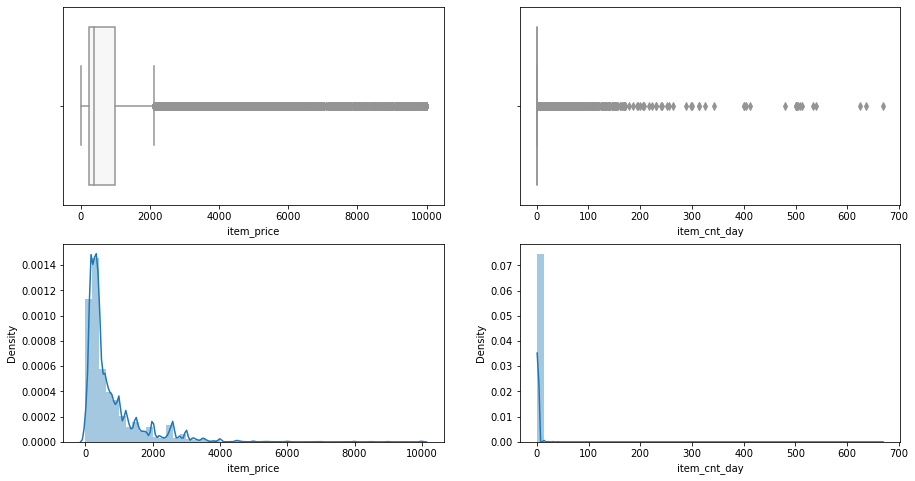

In [115]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
sns.boxplot(trainData['item_price'], palette='PRGn', ax = ax[0, 0])
sns.distplot(trainData['item_price'], ax = ax[1, 0])
sns.boxplot(trainData['item_cnt_day'], palette='PRGn', ax = ax[0, 1])
sns.distplot(trainData['item_cnt_day'], ax = ax[1, 1])

## Time Series Analysis

### Rolling mean and standard deviation graphs

In [116]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, period = 12, dft=False):
    movingAVG = df.rolling(window=period).mean()
    movingSTD = df.rolling(window=period).std()
    #plot
    plt.figure(figsize=(15, 10))
    df.plot(label='Original', alpha=0.3)
    mean = plt.plot(movingAVG, label='Rolling Mean')
    std = plt.plot(movingSTD, label='Rolling  Standard Deviation', alpha=0.5)
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    if dft:
        print('Results of Dickey-Fuller Test:')
        dftest = adfuller(df, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
        for key, value in dftest[4].items():
            dfoutput['\nCritical Value (%s)' % key] = value
        print(dfoutput)

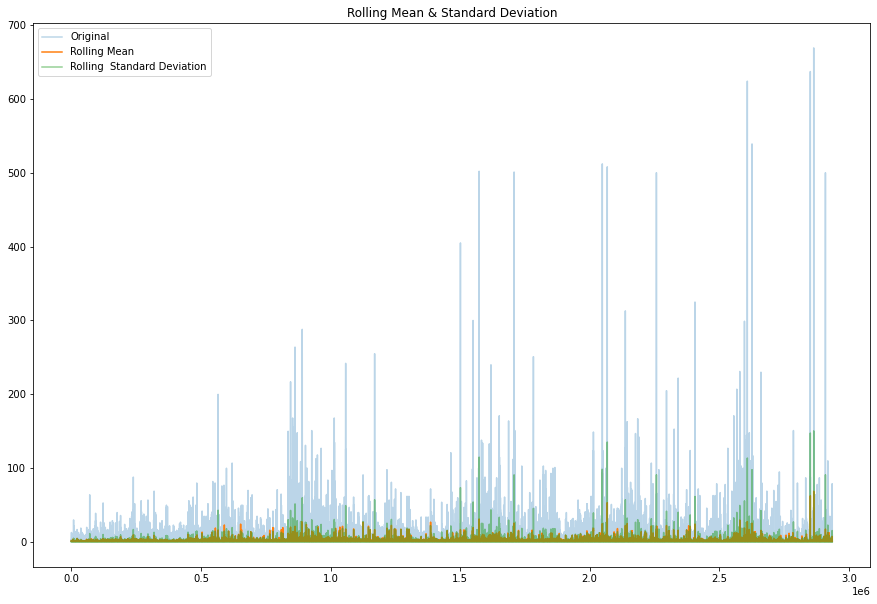

In [117]:
test_stationarity(trainData['item_cnt_day'], period = 30)

### Per month

In [110]:
trainData['Month'] = trainData['date'].dt.to_period('M')
trainData

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,Month
0,2013-02-01,0,59,22154,999.00,1.0,2013-02
1,2013-03-01,0,25,2552,899.00,1.0,2013-03
3,2013-06-01,0,25,2554,1709.05,1.0,2013-06
4,2013-01-15,0,25,2555,1099.00,1.0,2013-01
5,2013-10-01,0,25,2564,349.00,1.0,2013-10
...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,2015-10
2935845,2015-09-10,33,25,7460,299.00,1.0,2015-09
2935846,2015-10-14,33,25,7459,349.00,1.0,2015-10
2935847,2015-10-22,33,25,7440,299.00,1.0,2015-10


<AxesSubplot:xlabel='Month'>

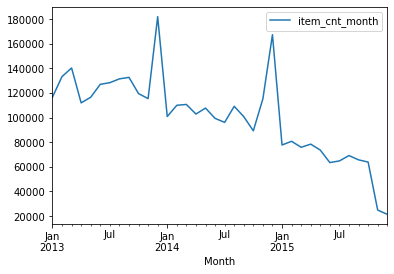

In [111]:
trainDataPerMonth = trainData.groupby(['Month']).agg({'item_cnt_day' : 'sum'})
trainDataPerMonth.reset_index(inplace=True)
trainDataPerMonth = trainDataPerMonth.set_index('Month')
trainDataPerMonth.rename(columns = {'item_cnt_day':'item_cnt_month'}, inplace = True)
trainDataPerMonth.plot()

### Decomposition Type and data transformation

In [97]:
#import the required modules for TimeSeries data generation:
import statsmodels.api as sm
def tsdisplay(y, figsize = (15, 10), title = "", lags = 12):
    tmp_data = y
    fig = plt.figure(figsize = figsize)
    #Plot the time series
    tmp_data.plot(ax = fig.add_subplot(311), title = "$Time\ Series\ " + title + "$", legend = False)
    #Plot the ACF:
    sm.graphics.tsa.plot_acf(tmp_data, lags = lags, zero = False, ax = fig.add_subplot(323))
    plt.xticks(np.arange(1,  lags + 1, 1.0))
    #Plot the PACF:
    sm.graphics.tsa.plot_pacf(tmp_data, lags = lags, zero = False, ax = fig.add_subplot(324))
    plt.xticks(np.arange(1,  lags + 1, 1.0))
    #Plot the QQ plot of the data:
    sm.qqplot(tmp_data, line='s', ax = fig.add_subplot(325)) 
    plt.title("QQ Plot")
    #Plot the residual histogram:
    fig.add_subplot(326).hist(tmp_data, bins = 40)
    plt.title("Histogram")
    #Fix the layout of the plots:
    plt.tight_layout()
    plt.show()

In [94]:
#Import the required modules for model estimation:
import statsmodels.tsa as smt
def decomposition(df):
    log_passengers = np.log(df)
    decomposition_1  = smt.seasonal.seasonal_decompose(log_passengers, model = "additive", freq = 12, two_sided = True)
    fig, ax = plt.subplots(4, 1, figsize=(15, 8))
    # Plot the series
    decomposition_1.observed.plot(ax = ax[0])
    decomposition_1.trend.plot(ax = ax[1])
    decomposition_1.seasonal.plot(ax = ax[2])
    decomposition_1.resid.plot(ax = ax[3])
    # Add the labels to the Y-axis
    ax[0].set_ylabel('Observed')
    ax[1].set_ylabel('Trend')
    ax[2].set_ylabel('Seasonal')
    ax[3].set_ylabel('Residual')
    # Fix layout
    plt.tight_layout()
    plt.show()

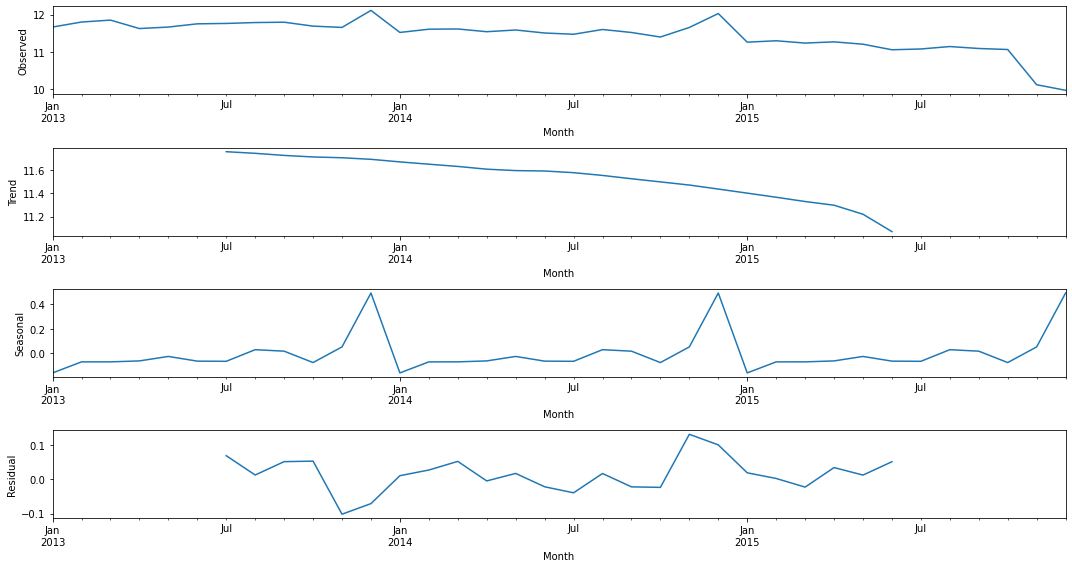

In [80]:
decomposition(trainDataPerMonth)

Results of Dickey-Fuller Test:
Test Statistic                 -0.118087
p-value                         0.947607
#Lags Used                      2.000000
Number of Observations Used    33.000000
\nCritical Value (1%)          -3.646135
\nCritical Value (5%)          -2.954127
\nCritical Value (10%)         -2.615968
dtype: float64


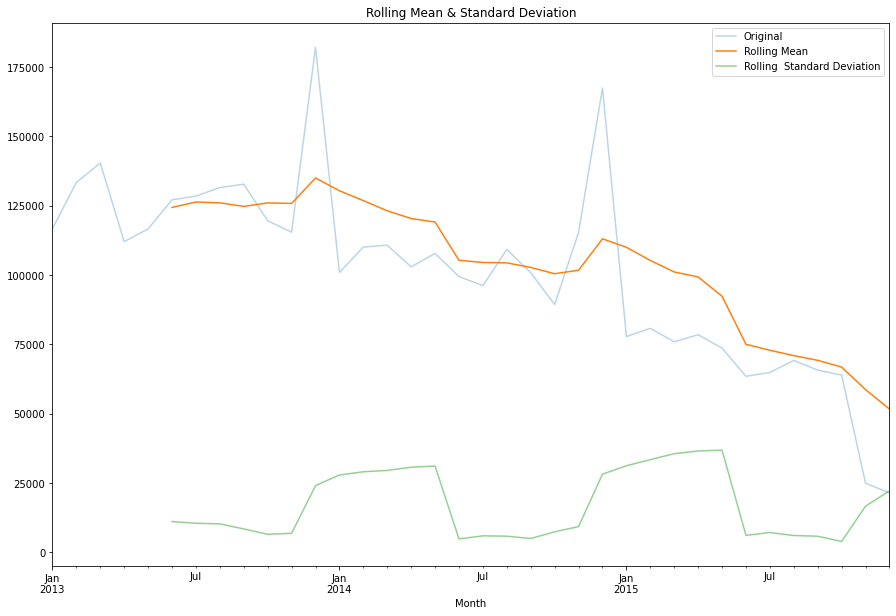

In [89]:
test_stationarity(trainDataPerMonth['item_cnt_month'], 6, True)

The p-value is greater than the critical value of 0.05. The series is not stationary

## Forecasting

<AxesSubplot:xlabel='Month'>

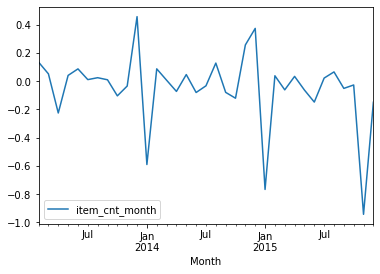

In [82]:
log_passengers = np.log(trainDataPerMonth)
trainDataPerMonthShift = log_passengers - log_passengers.shift()
trainDataPerMonthShift.dropna(inplace=True)
trainDataPerMonthShift.plot()

Results of Dickey-Fuller Test:
Test Statistic                -7.109569e+00
p-value                        3.971395e-10
#Lags Used                     0.000000e+00
Number of Observations Used    3.400000e+01
\nCritical Value (1%)         -3.639224e+00
\nCritical Value (5%)         -2.951230e+00
\nCritical Value (10%)        -2.614447e+00
dtype: float64


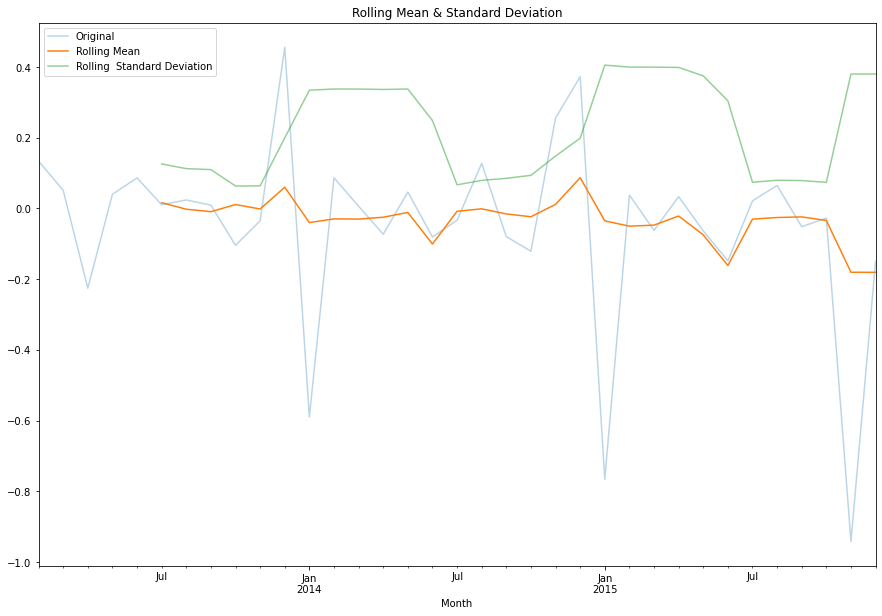

In [88]:
test_stationarity(trainDataPerMonthShift['item_cnt_month'], 6, True)

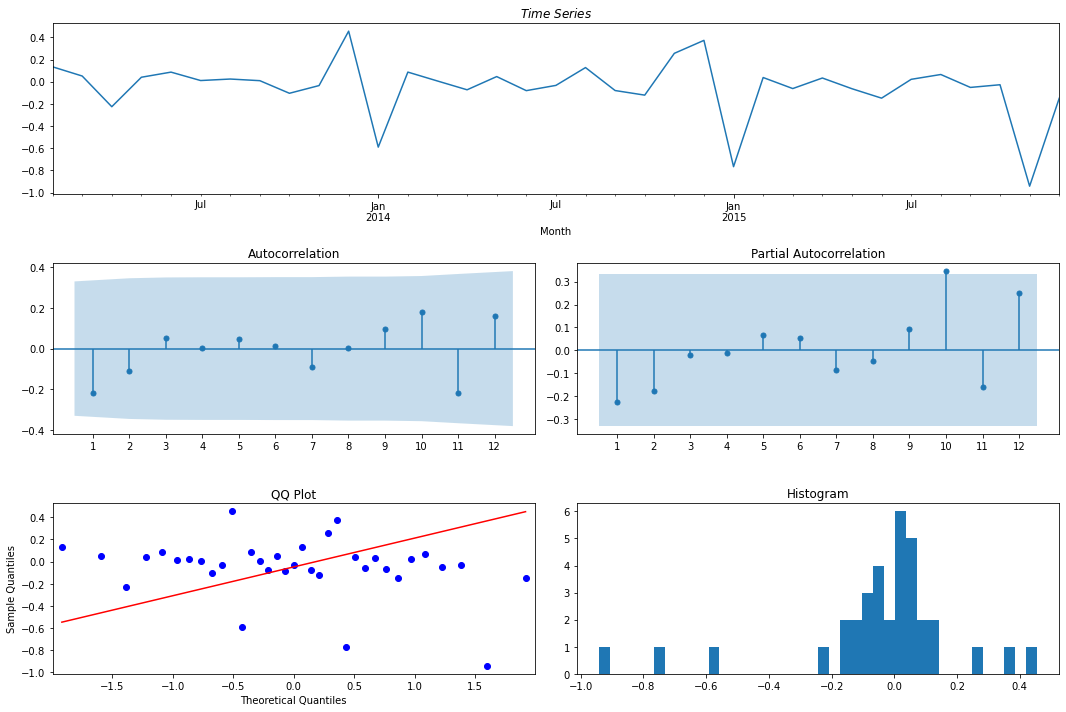

In [98]:
 tsdisplay(trainDataPerMonthShift)

### Train Test Split

Train dates : 2013-02 --- 2015-03  (n=26)
Test dates  : 2015-04 --- 2015-12  (n=9)


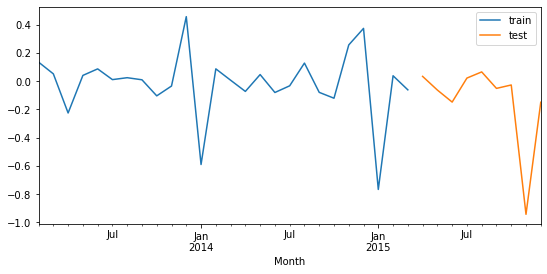

In [99]:
from sklearn.linear_model import LinearRegression

train = trainDataPerMonthShift[:STEPS]
test = trainDataPerMonthShift[STEPS:]


print(f"Train dates : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates  : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

fig, ax = plt.subplots(figsize=(9, 4))
train['item_cnt_month'].plot(ax=ax, label='train')
test['item_cnt_month'].plot(ax=ax, label='test')
ax.legend()


RSS: 2.4034
plotting ARIMA model


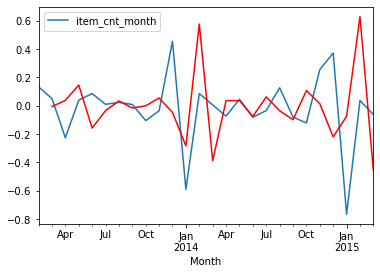

In [100]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train, order=(1,1,0))
results_ARIMA = model.fit(disp=-1)
train.plot()
plt.plot(results_ARIMA.fittedvalues, color='red')
print('RSS: %.4f' %sum((results_ARIMA.fittedvalues-train['item_cnt_month'])[1:]**2))
print("plotting ARIMA model")

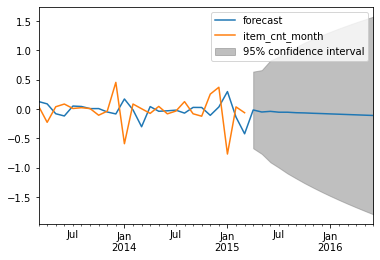

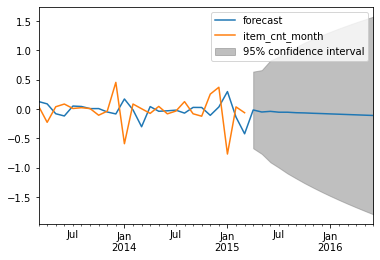

In [101]:
results_ARIMA.plot_predict(1,40)

In [102]:
x = results_ARIMA.forecast(steps=9)[0]
x 

array([-0.01461889, -0.04954295, -0.03836613, -0.05300859, -0.05319069,
       -0.06147147, -0.0652165 , -0.07150182, -0.07636442])

In [103]:

from sklearn.metrics import mean_squared_error
mean_squared_error(x,test['item_cnt_month'])


0.08877068367669559

In [104]:
pred = pd.Series(x, index = test.index)

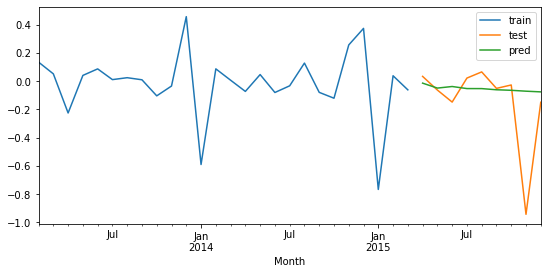

In [105]:
fig, ax = plt.subplots(figsize=(9, 4))
train['item_cnt_month'].plot(ax=ax, label='train')
test['item_cnt_month'].plot(ax=ax, label='test')
pred.plot(label='pred')
ax.legend()

New

Results of Dickey-Fuller Test:
Test Statistic                -6.985474e+00
p-value                        7.989642e-10
#Lags Used                     1.000000e+00
Number of Observations Used    3.300000e+01
\nCritical Value (1%)         -3.646135e+00
\nCritical Value (5%)         -2.954127e+00
\nCritical Value (10%)        -2.615968e+00
dtype: float64


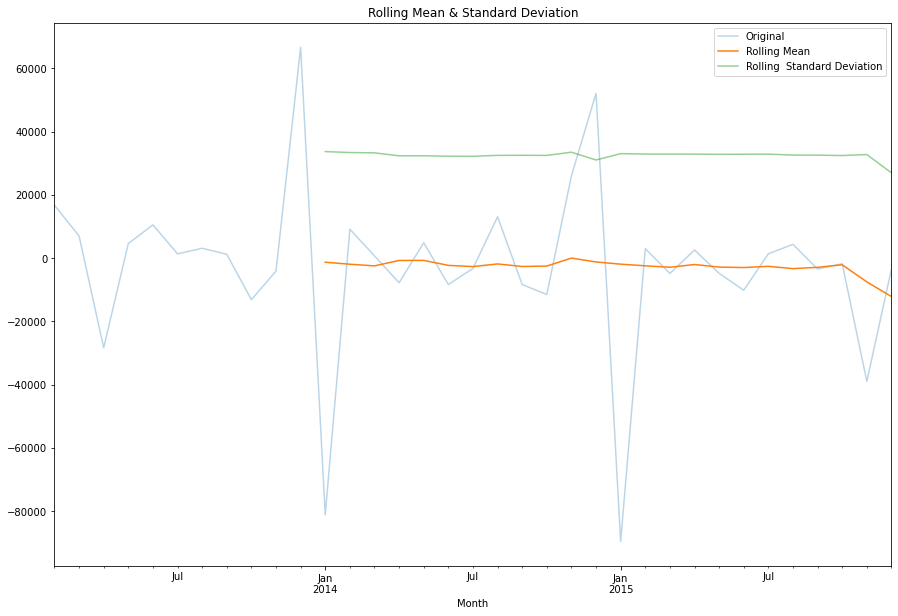

In [129]:
trainDataPerMonthDiff = trainDataPerMonth - trainDataPerMonth.shift()
trainDataPerMonthDiff = trainDataPerMonthDiff.dropna()
test_stationarity(trainDataPerMonthDiff['item_cnt_month'], 12, True)

In [138]:
import pmdarima as pm
from pmdarima.arima import auto_arima
model = auto_arima(
    y=trainDataPerMonthDiff[:STEPS],
    seasonal=True,
    start_p = 1, max_p =5,
    start_q =1, max_q =5,
    d = None,
    start_P = 1, max_P =5,
    start_Q =1, max_Q =5,
    D = None,
    m=12,)

In [139]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   26
Model:             SARIMAX(0, 0, 1)x(1, 0, [], 12)   Log Likelihood                -296.624
Date:                             Tue, 02 Aug 2022   AIC                            599.248
Time:                                     20:09:46   BIC                            603.023
Sample:                                          0   HQIC                           600.335
                                              - 26                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7389      0.350     -2.109      0.035      -1.425      -0.052
ar.S.L12       0.5628      0.244      2.304      0.021       0.084       1.042
sigma2      6.768e+08   1.11e-10   6.12e+18      0.000    6.77e+08    6.77e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 7.59
Prob(Q):                              0.89   Prob(JB):                         0.02
Heteroskedasticity (H):               4.37   Skew:                             1.13
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.5e+34. Standard errors may be unstable.
"""

In [167]:
prediction, confint = model.predict(n_periods=12, return_conf_int=True)
confint_df = pd.DataFrame(confint)
prediction

array([  9518.37639042,   2731.24242696,  -4706.08884696,  -1840.33849911,
         7345.59574629,  -4713.40517738,  -6477.766399  ,  14640.53997425,
        29303.02893978, -50431.4656167 ,   1676.56525653,  -2733.49360556])

In [168]:
period_index = pd.period_range(
    start = trainDataPerMonthDiff[:STEPS].index[-1],
    periods = 12,
    freq='M'
)
predicted_df = pd.DataFrame({'value':prediction}, index=period_index)
predicted_df

,value
2015-03,9518.376390
2015-04,2731.242427
2015-05,-4706.088847
2015-06,-1840.338499
2015-07,7345.595746
2015-08,-4713.405177
2015-09,-6477.766399
2015-10,14640.539974
2015-11,29303.028940
2015-12,-50431.465617


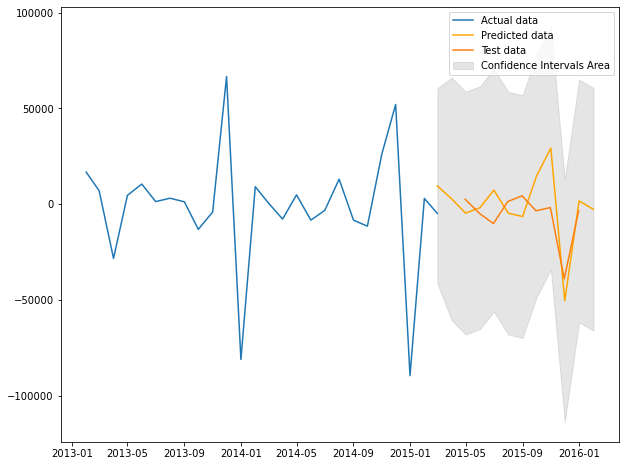

In [171]:
plt.figure(figsize=(10, 8))
plt.plot(trainDataPerMonthDiff[:STEPS].to_timestamp(), label='Actual data')
plt.plot(predicted_df.to_timestamp(), color='orange', label='Predicted data')
plt.plot(trainDataPerMonthDiff[STEPS:], label='Test data')
plt.fill_between(period_index.to_timestamp(), confint_df[0], confint_df[1],color='grey',alpha=.2, label='Confidence Intervals Area')
plt.legend()
plt.show()